In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from tqdm import tqdm, trange
import seaborn as sns
import random
from copy import deepcopy

In [2]:
class CFG:
    height = 6
    width = 9
    start = [5, 3]
    goal  = [0, 8]
    action_Up = [-1, 0]
    action_Down = [1, 0]
    action_Left = [0, -1]
    action_Right = [0, 1]
    actions = [action_Up, action_Down, action_Left, action_Right]
    alpha = 0.1
    epsilon = 0.1
    max_step = 3000
    step_change = 1000
    n_run = 10
    n_plan = 5
    garma = 0.95

In [3]:
otc = [(3, 0),(3, 1),(3, 2),(3, 3),(3, 4),(3, 5), (3, 6),(3, 7)]
change_otc = [(3, 1),(3, 2),(3, 3),(3, 4),(3, 5), (3, 6),(3, 7), (3,8)]

def go(curX, curY, action, otc):
    [tmpX, tmpY] = CFG.actions[action]
    nextX = max(0, min(curX + tmpX, CFG.height - 1))
    nextY = max(0, min(curY + tmpY, CFG.width - 1))
    if ((nextX, nextY) in otc):
        (nextX, nextY) = (curX, curY)
    return (nextX, nextY)

def step(curX, curY, action, otc):
    (nextX, nextY) = go(curX, curY, action, otc)
    if ([nextX, nextY] == CFG.goal):
        return ([nextX, nextY], 1, True)
#     if ([nextX, nextY] == [curX, curY]):
#         return([nextX, nextY], -1, False)
    return ([nextX, nextY], 0, False)

In [4]:
def dyna_Q(n_plan, n_run = CFG.n_run, max_step = CFG.max_step):
    res = np.zeros((max_step+1))
    for r in trange(n_run, desc = f'n = {n_plan}'):
        # Q = np.random.random((CFG.height, CFG.width, 4))
        time = 0
        Q = np.zeros(((CFG.height, CFG.width, 4)))
        model = {}
        while (time <= max_step):
            [curX, curY] = CFG.start
            while(True):
                    
                if(time>max_step):
                    break
                if (np.random.random()<CFG.epsilon):
                    action = np.random.choice(np.arange(4))
                else:
                    set_actions = Q[curX, curY,:] == np.max(Q[curX, curY, :])
                    actions = []
                    for i in range(4):
                        if (set_actions[i] == 1):
                            actions.append(i)
                    action = np.random.choice(actions)
                
                if (time >= CFG.step_change):
                    cur_otc = change_otc
                else:
                    cur_otc = otc
                (Nstate, reward, done) = step(curX, curY, action, cur_otc)
                res[time] += reward
                [nextX, nextY] = Nstate
#                 print(ep, (curX, curY), action, (nextX, nextY))
                Q[curX, curY, action] += CFG.alpha * (reward + CFG.garma * np.max(Q[nextX, nextY, :]) - Q[curX, curY, action])
                model[((curX, curY), action)] = ((nextX, nextY), reward)

                for _ in range(n_plan):
                    idx = np.random.choice(range(len(model.keys())))
                    ((tmpX, tmpY), tmp_action) = list(model.keys())[idx]
                    ((tmp_NX, tmp_NY), tmp_reward) = model[((tmpX, tmpY), tmp_action)]
                    Q[tmpX, tmpY, tmp_action] += CFG.alpha * (tmp_reward + CFG.garma * np.max(Q[tmp_NX, tmp_NY, :]) - Q[tmpX, tmpY, tmp_action])
                time += 1
                if (done):
                    break
                (curX, curY) = (nextX, nextY)
            
    return np.add.accumulate(res/n_run)


In [37]:
def dyna_Q_plus(n_plan, n_run = CFG.n_run, max_step = CFG.max_step):
    res = np.zeros((max_step+1))
    for r in trange(n_run, desc = f'n = {n_plan}'):
        # Q = np.random.random((CFG.height, CFG.width, 4))
        time = 0
        Q = np.zeros(((CFG.height, CFG.width, 4)), dtype = float)
        model = {}
        while (time <= max_step):
            [curX, curY] = CFG.start
            while(True):
                    
                if(time>max_step):
                    break
                if (np.random.random()<CFG.epsilon):
                    action = np.random.choice(np.arange(4))
                else:
                    set_actions = Q[curX, curY,:] == np.max(Q[curX, curY, :])
                    actions = []
                    for i in range(4):
                        if (set_actions[i] == 1):
                            actions.append(i)
                    action = np.random.choice(actions)
                
                if (time >= CFG.step_change):
                    cur_otc = change_otc
                else:
                    cur_otc = otc
                (Nstate, reward, done) = step(curX, curY, action, cur_otc)
                res[time] += reward
                [nextX, nextY] = Nstate
#                 print(ep, (curX, curY), action, (nextX, nextY))
                Q[curX, curY, action] += CFG.alpha * (reward + CFG.garma * np.max(Q[nextX, nextY, :]) - Q[curX, curY, action])
                model[deepcopy(((curX, curY), action))] = deepcopy(((nextX, nextY), reward, time))

                for _ in range(n_plan):
                    idx = np.random.choice(range(len(model.keys())))
                    ((tmpX, tmpY), tmp_action) = list(model.keys())[idx]
                    ((tmp_NX, tmp_NY), tmp_reward, last_time) = model[((tmpX, tmpY), tmp_action)]
                    copy_reward = deepcopy(tmp_reward)
                    copy_reward +=  np.sqrt(time - last_time)
#                     print(f'--------{time}_{_}----------')
#                     print(Q[tmpX, tmpY, tmp_action])
                    Q[tmpX, tmpY, tmp_action] += CFG.alpha * (copy_reward + CFG.garma * np.max(Q[tmp_NX, tmp_NY, :]) - Q[tmpX, tmpY, tmp_action])
#                     print(tmpX, tmpY, tmp_action)
#                     print(Q[tmpX, tmpY, tmp_action])
                time += 1
                if (done):
                    break
                (curX, curY) = (nextX, nextY)
            
    return np.add.accumulate(res/n_run)


In [38]:
# res = dyna_Q_plus(5)
# res = np.add.accumulate(res)

n = 5: 100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


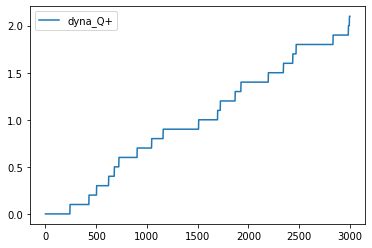

In [39]:
# plt.plot(dyna_Q(5), label = 'dyna_Q')
plt.plot(dyna_Q_plus(5), label = 'dyna_Q+')
plt.legend()
plt.show()

In [27]:
# plt.plot(dyna_Q(5), label = 'dyna_Q')
plt.plot(dyna_Q_plus(5), label = 'dyna_Q+')
plt.legend()
plt.show()

n = 5:   0%|          | 0/10 [00:00<?, ?it/s]

--------0_0----------
0.0
5 3 2
0.0
--------0_1----------
0.0
5 3 2
0.0
--------0_2----------
0.0
5 3 2
0.0
--------0_3----------
0.0
5 3 2
0.0
--------0_4----------
0.0
5 3 2
0.0
--------1_0----------
0.0
5 2 3
0.0
--------1_1----------
0.0
5 2 3
0.0
--------1_2----------
0.0
5 2 3
0.0
--------1_3----------
0.0
5 2 3
0.0
--------1_4----------
0.0
5 2 3
0.0
--------2_0----------
0.0
5 2 3
0.0
--------2_1----------
0.0
5 3 2
0.0
--------2_2----------
0.0
5 2 3
0.0
--------2_3----------
0.0
5 3 0
0.0
--------2_4----------
0.0
5 3 2
0.0
--------3_0----------
0.0
5 3 2
0.0
--------3_1----------
0.0
4 3 0
0.0
--------3_2----------
0.0
5 3 0
0.0
--------3_3----------
0.0
5 3 2
0.0
--------3_4----------
0.0
5 3 2
0.0
--------4_0----------
0.0
5 3 2
0.0
--------4_1----------
0.0
4 3 2
0.0
--------4_2----------
0.0
4 3 0
0.0
--------4_3----------
0.0
5 2 3
0.0
--------4_4----------
0.0
4 3 2
0.0
--------5_0----------
0.0
4 3 0
0.0
--------5_1----------
0.0
4 3 2
0.0
--------5_2----------
0.0
4 

0.0
5 5 0
0.0
--------49_0----------
0.0
5 6 2
0.0
--------49_1----------
0.0
5 4 0
0.0
--------49_2----------
0.0
4 2 2
0.0
--------49_3----------
0.0
4 2 2
0.0
--------49_4----------
0.0
4 2 2
0.0
--------50_0----------
0.0
5 2 1
0.0
--------50_1----------
0.0
4 6 3
0.0
--------50_2----------
0.0
5 0 2
0.0
--------50_3----------
0.0
5 4 3
0.0
--------50_4----------
0.0
5 4 0
0.0
--------51_0----------
0.0
5 5 0
0.0
--------51_1----------
0.0
5 4 0
0.0
--------51_2----------
0.0
4 0 2
0.0
--------51_3----------
0.0
5 1 3
0.0
--------51_4----------
0.0
5 1 1
0.0
--------52_0----------
0.0
4 4 1
0.0
--------52_1----------
0.0
5 5 2
0.0
--------52_2----------
0.0
4 1 0
0.0
--------52_3----------
0.0
4 2 1
0.0
--------52_4----------
0.0
5 5 3
0.0
--------53_0----------
0.0
5 5 3
0.0
--------53_1----------
0.0
4 6 3
0.0
--------53_2----------
0.0
4 0 2
0.0
--------53_3----------
0.0
4 4 1
0.0
--------53_4----------
0.0
5 5 2
0.0
--------54_0----------
0.0
4 0 1
0.0
--------54_1----------
0

--------103_3----------
0.0
4 1 1
0.0
--------103_4----------
0.0
5 7 2
0.0
--------104_0----------
0.0
4 7 2
0.0
--------104_1----------
0.0
5 2 2
0.0
--------104_2----------
0.0
5 5 1
0.0
--------104_3----------
0.0
4 1 1
0.0
--------104_4----------
0.0
5 6 2
0.0
--------105_0----------
0.0
5 5 0
0.0
--------105_1----------
0.0
5 0 3
0.0
--------105_2----------
0.0
4 5 1
0.0
--------105_3----------
0.0
5 0 1
0.0
--------105_4----------
0.0
5 5 2
0.0
--------106_0----------
0.0
5 1 3
0.0
--------106_1----------
0.0
5 2 2
0.0
--------106_2----------
0.0
5 5 2
0.0
--------106_3----------
0.0
5 7 2
0.0
--------106_4----------
0.0
4 1 2
0.0
--------107_0----------
0.0
4 2 1
0.0
--------107_1----------
0.0
4 1 1
0.0
--------107_2----------
0.0
4 2 2
0.0
--------107_3----------
0.0
4 4 1
0.0
--------107_4----------
0.0
4 7 1
0.0
--------108_0----------
0.0
5 1 3
0.0
--------108_1----------
0.0
5 8 1
0.0
--------108_2----------
0.0
5 5 3
0.0
--------108_3----------
0.0
4 8 2
0.0
--------108_

--------151_0----------
0.0
4 5 2
0.0
--------151_1----------
0.0
5 5 3
0.0
--------151_2----------
0.0
5 5 2
0.0
--------151_3----------
0.0
5 2 0
0.0
--------151_4----------
0.0
4 3 2
0.0
--------152_0----------
0.0
4 5 0
0.0
--------152_1----------
0.0
5 4 1
0.0
--------152_2----------
0.0
4 3 3
0.0
--------152_3----------
0.0
4 7 2
0.0
--------152_4----------
0.0
5 4 0
0.0
--------153_0----------
0.0
5 8 0
0.0
--------153_1----------
0.0
5 5 0
0.0
--------153_2----------
0.0
5 2 0
0.0
--------153_3----------
0.0
4 4 2
0.0
--------153_4----------
0.0
4 4 3
0.0
--------154_0----------
0.0
4 3 1
0.0
--------154_1----------
0.0
4 0 1
0.0
--------154_2----------
0.0
4 4 2
0.0
--------154_3----------
0.0
4 1 3
0.0
--------154_4----------
0.0
4 8 2
0.0
--------155_0----------
0.0
5 6 3
0.0
--------155_1----------
0.0
4 0 2
0.0
--------155_2----------
0.0
5 8 3
0.0
--------155_3----------
0.0
5 8 3
0.0
--------155_4----------
0.0
5 1 0
0.0
--------156_0----------
0.0
4 8 2
0.0
--------156_

--------197_1----------
0.0
5 8 0
0.0
--------197_2----------
0.0
4 2 1
0.0
--------197_3----------
0.0
4 0 1
0.0
--------197_4----------
0.0
5 0 3
0.0
--------198_0----------
0.0
4 3 2
0.0
--------198_1----------
0.0
4 6 1
0.0
--------198_2----------
0.0
4 3 1
0.0
--------198_3----------
0.0
4 1 2
0.0
--------198_4----------
0.0
5 2 1
0.0
--------199_0----------
0.0
4 2 3
0.0
--------199_1----------
0.0
5 3 3
0.0
--------199_2----------
0.0
4 1 3
0.0
--------199_3----------
0.0
4 6 1
0.0
--------199_4----------
0.0
4 1 0
0.0
--------200_0----------
0.0
5 0 3
0.0
--------200_1----------
0.0
4 7 1
0.0
--------200_2----------
0.0
5 4 2
0.0
--------200_3----------
0.0
5 1 2
0.0
--------200_4----------
0.0
5 6 0
0.0
--------201_0----------
0.0
4 2 2
0.0
--------201_1----------
0.0
4 0 1
0.0
--------201_2----------
0.0
4 0 1
0.0
--------201_3----------
0.0
5 2 0
0.0
--------201_4----------
0.0
4 1 2
0.0
--------202_0----------
0.0
4 2 0
0.0
--------202_1----------
0.0
4 0 2
0.0
--------202_

--------247_4----------
0.0
3 8 3
0.0
--------248_0----------
0.0
4 8 2
0.0
--------248_1----------
0.0
5 5 3
0.0
--------248_2----------
0.0
4 8 3
0.0
--------248_3----------
0.0
4 1 3
0.0
--------248_4----------
0.0
4 4 2
0.0
--------249_0----------
0.0
4 4 2
0.0
--------249_1----------
0.0
4 2 3
0.0
--------249_2----------
0.0
5 4 2
0.0
--------249_3----------
0.0
4 4 1
0.0
--------249_4----------
0.0
5 8 0
0.0
--------250_0----------
0.0
4 1 3
0.0
--------250_1----------
0.0
4 8 3
0.0
--------250_2----------
0.0
5 3 3
0.0
--------250_3----------
0.0
5 6 1
0.0
--------250_4----------
0.0
4 2 0
0.0
--------251_0----------
0.0
5 5 0
0.0
--------251_1----------
0.0
4 2 1
0.0
--------251_2----------
0.0
4 4 3
0.0
--------251_3----------
0.0
5 7 2
0.0
--------251_4----------
0.0
5 3 2
0.0
--------252_0----------
0.0
4 3 0
0.0
--------252_1----------
0.0
4 4 1
0.0
--------252_2----------
0.0
4 1 1
0.0
--------252_3----------
0.0
5 8 1
0.0
--------252_4----------
0.0
4 2 0
0.0
--------253_

--------335_0----------
0.0
3 8 3
0.0
--------335_1----------
0.0
5 0 2
0.0
--------335_2----------
0.0
4 3 2
0.0
--------335_3----------
0.0
5 5 3
0.0
--------335_4----------
0.0
2 7 2
0.0
--------336_0----------
0.0
4 2 3
0.0
--------336_1----------
0.0
3 8 3
0.0
--------336_2----------
0.0
2 5 3
0.0
--------336_3----------
0.0
5 8 1
0.0
--------336_4----------
0.0
4 3 3
0.0
--------337_0----------
0.0
5 7 3
0.0
--------337_1----------
0.0
3 8 3
0.0
--------337_2----------
0.0
0 6 3
0.0
--------337_3----------
0.0
4 1 3
0.0
--------337_4----------
0.0
2 8 1
0.0
--------338_0----------
0.0
5 8 2
0.0
--------338_1----------
0.0
4 5 0
0.0
--------338_2----------
0.0
1 7 1
0.0
--------338_3----------
0.0
4 0 2
0.0
--------338_4----------
0.0
3 8 0
0.0
--------339_0----------
0.0
0 7 1
0.0
--------339_1----------
0.0
2 7 3
0.0
--------339_2----------
0.0
5 3 2
0.0
--------339_3----------
0.0
2 7 2
0.0
--------339_4----------
0.0
4 0 1
0.0
--------340_0----------
0.0
5 8 2
0.0
--------340_

--------383_0----------
0.0
5 7 3
0.0
--------383_1----------
0.0
5 8 2
0.0
--------383_2----------
0.0
4 8 3
0.0
--------383_3----------
0.0
5 1 3
0.0
--------383_4----------
0.0
4 8 0
0.0
--------384_0----------
0.0
4 5 1
0.0
--------384_1----------
0.0
4 6 2
0.0
--------384_2----------
0.0
4 8 1
0.0
--------384_3----------
0.0
4 6 3
0.0
--------384_4----------
0.0
2 7 1
0.0
--------385_0----------
0.0
5 3 0
0.0
--------385_1----------
0.0
1 7 1
0.0
--------385_2----------
0.0
4 1 1
0.0
--------385_3----------
0.0
4 7 2
0.0
--------385_4----------
0.0
4 0 0
0.0
--------386_0----------
0.0
5 4 1
0.0
--------386_1----------
0.0
4 4 1
0.0
--------386_2----------
0.0
4 5 0
0.0
--------386_3----------
0.0
4 0 0
0.0
--------386_4----------
0.0
2 5 3
0.0
--------387_0----------
0.0
2 7 3
0.0009025000000000002
--------387_1----------
0.0
4 8 0
0.0
--------387_2----------
0.0
4 2 1
0.0
--------387_3----------
0.0
4 6 3
0.0
--------387_4----------
0.0
4 7 2
0.0
--------388_0----------
0.0
2 8 

1 7 1
0.0044600016309098755
--------432_1----------
0.10169550500000002
2 8 0
0.1304294045
--------432_2----------
0.0
5 6 2
0.0
--------432_3----------
0.0006296647737500001
3 8 2
0.0011963630701250002
--------432_4----------
0.0
0 6 3
0.0
--------433_0----------
0.0
5 7 3
0.0
--------433_1----------
0.0
2 7 2
0.0
--------433_2----------
0.0
4 0 3
0.0
--------433_3----------
0.0
4 8 2
0.0
--------433_4----------
0.0
5 4 3
0.0
--------434_0----------
0.0
5 5 0
0.0
--------434_1----------
0.0
5 8 2
0.0
--------434_2----------
0.0
4 3 2
0.0
--------434_3----------
0.1304294045
2 8 0
0.15628991405
--------434_4----------
0.0
5 8 0
0.0
--------435_0----------
0.013324320475000002
2 7 3
0.02683943026225
--------435_1----------
0.0
4 4 3
0.0
--------435_2----------
0.0
2 6 0
0.0
--------435_3----------
0.0
4 4 3
0.0
--------435_4----------
0.0
5 3 1
0.0
--------436_0----------
0.0
4 2 1
0.0
--------436_1----------
0.0
0 6 3
0.0
--------436_2----------
0.0
3 8 1
0.0
--------436_3----------
0.

4 4 0
0.0
--------478_4----------
0.0
5 6 3
0.0
--------479_0----------
0.049950267998447505
2 7 3
0.06635931694425026
--------479_1----------
0.010652648068311886
1 7 1
0.015891518371184472
--------479_2----------
0.0
5 6 3
0.0
--------479_3----------
0.0
5 3 2
0.0
--------479_4----------
0.0
5 8 2
0.0
--------480_0----------
0.0
5 5 1
0.0
--------480_1----------
0.0
5 3 3
0.0
--------480_2----------
0.0
4 4 3
0.0
--------480_3----------
0.0
5 4 3
0.0
--------480_4----------
0.0
5 2 1
0.0
--------481_0----------
0.0037567080642848757
2 8 1
0.008285433244811789
--------481_1----------
0.0
5 6 2
0.0
--------481_2----------
0.0
4 5 3
0.0
--------481_3----------
0.0
5 2 2
0.0
--------481_4----------
0.0
4 2 1
0.0
--------482_0----------
0.0
5 6 2
0.0
--------482_1----------
0.0
4 7 2
0.0
--------482_2----------
0.014202119862250001
2 7 0
0.030703849181800004
--------482_3----------
0.0
5 6 0
0.0
--------482_4----------
0.0
4 6 1
0.0
--------483_0----------
0.0029897652145512506
2 7 1
0.00

0.0
--------526_2----------
0.0
5 1 0
0.0
--------526_3----------
0.0
4 5 2
0.0
--------526_4----------
0.00045324402688390656
4 7 0
0.0010546141173338242
--------527_0----------
0.0
4 5 2
0.0
--------527_1----------
0.0
4 1 3
0.0
--------527_2----------
0.0
4 4 3
0.0
--------527_3----------
0.0
4 4 3
0.0
--------527_4----------
0.008285433244811789
2 8 1
0.018502290353750468
--------528_0----------
0.013408433801312411
0 6 3
0.019232437020752093
--------528_1----------
0.0
4 2 0
0.0
--------528_2----------
0.11689767005000003
1 8 3
0.16708345123550003
--------528_3----------
0.0
4 1 3
0.0
--------528_4----------
0.0
5 0 3
0.0
--------529_0----------
0.018502290353750468
2 8 1
0.02769746175179528
--------529_1----------
0.0
4 1 0
0.0
--------529_2----------
0.0
4 4 0
0.0
--------529_3----------
0.0
5 7 1
7.713363764420258e-05
--------529_4----------
0.0
5 4 1
0.0
--------530_0----------
0.0
3 8 1
0.002758890924722691
--------530_1----------
0.020675877001486355
3 8 2
0.0296536897347575

--------574_0----------
9.227983554192747e-07
5 5 2
2.5484892162055453e-06
--------574_1----------
0.0
5 0 0
6.129488235546025e-12
--------574_2----------
3.234901983942107e-08
5 2 3
2.1066368207006675e-07
--------574_3----------
0.00044087475834086765
5 6 3
0.000553379077282552
--------574_4----------
0.0
5 1 2
2.7735240884823638e-11
--------575_0----------
3.234901983942107e-08
4 3 1
2.1066368207006675e-07
--------575_1----------
4.0872986567108516e-11
4 2 2
1.0130661670561897e-10
--------575_2----------
0.0009405394610731809
4 5 3
0.0012117014760561094
--------575_3----------
0.0
5 0 2
2.7735240884823638e-11
--------575_4----------
0.0
4 3 2
2.919499040507752e-10
--------576_0----------
0.0
5 2 2
2.9194990405077514e-10
--------576_1----------
0.00013252225470303204
2 7 2
0.0001657058059891544
--------576_2----------
0.1209502301028483
2 8 3
0.14670182580693475
--------576_3----------
3.0731568847450016e-09
4 2 3
1.1129916160782657e-06
--------576_4----------
0.0
5 2 0
1.057342035274

--------621_0----------
0.16848346065223857
2 7 0
0.19506847328001442
--------621_1----------
0.00046887904745931134
5 6 0
0.0021418592538629067
--------621_2----------
0.04109152151662243
5 8 0
0.051415503799567656
--------621_3----------
0.08968686607065525
1 7 1
0.10151477996424105
--------621_4----------
9.548836870925762e-05
5 5 1
0.00018287501952780454
--------622_0----------
0.0010203735546260282
5 5 0
0.0015364958578298923
--------622_1----------
1.27975295979693e-05
5 4 1
3.583331967750902e-05
--------622_2----------
2.3086441063332283e-05
2 6 2
4.6219274375201235e-05
--------622_3----------
9.000482775801058e-11
4 1 2
7.239286941661603e-10
--------622_4----------
6.494692934598133e-06
4 3 1
1.2150319261873392e-05
--------623_0----------
7.239286941661603e-10
4 1 2
1.2944601739334949e-09
--------623_1----------
0.0012491557901528505
2 6 0
0.0019334781162295422
--------623_2----------
0.0021418592538629067
5 6 0
0.0036475414396261426
--------623_3----------
0.2075504992644714
0

--------668_0----------
1.5150397399280322e-09
5 0 0
4.2808068358907266e-09
--------668_1----------
5.565990668891426e-06
4 2 0
7.244981185152463e-06
--------668_2----------
2.3532521927896624e-05
4 2 3
6.008858321041605e-05
--------668_3----------
1.6468371797194263e-06
5 3 2
7.198279933142808e-06
--------668_4----------
7.200564892496137e-09
5 0 2
1.6539087707261226e-08
--------669_0----------
0.00014596710649383975
4 5 1
0.0006813335072156089
--------669_1----------
1.0011465565722102e-07
4 1 1
1.2800357373239244e-07
--------669_2----------
0.11046796019085905
2 8 2
0.1309802964083646
--------669_3----------
1.2800357373239244e-07
4 1 1
1.5310360000004672e-07
--------669_4----------
0.00019177285279810087
5 4 0
0.0003943218437756408
--------670_0----------
0.0005183086090703366
4 5 2
0.000688204024420653
--------670_1----------
0.003847077161258845
4 5 0
0.005406675630132186
--------670_2----------
0.22672392121233734
2 7 0
0.25869750571046907
--------670_3----------
0.1446973136199

4 6 3
0.13556492182029847
--------715_3----------
0.03798655877769726
4 8 1
0.044765663569907105
--------715_4----------
3.6568257554971626e-05
5 2 0
4.966434123558986e-05
--------716_0----------
0.013776203006408815
4 6 2
0.01768162732329879
--------716_1----------
0.00011575492821461142
4 3 0
0.00022644612562077997
--------716_2----------
6.144019141383804e-06
4 2 2
7.394603279224071e-06
--------716_3----------
0.0009050222772279814
4 4 1
0.001346656973132322
--------716_4----------
5.813577219778292e-06
4 2 1
1.9587247371589484e-05
--------717_0----------
0.001003646358185129
4 5 2
0.00242410386959804
--------717_1----------
6.1343150846349325e-06
4 1 0
7.385869628150086e-06
--------717_2----------
3.070811652584734e-08
4 0 3
1.8926233568519099e-06
--------717_3----------
0.024866965565439533
4 7 2
0.035258936581823934
--------717_4----------
0.10127222584948611
3 8 1
0.13121653834059133
--------718_0----------
0.001287017791869786
4 3 3
0.0026791381599142313
--------718_1----------

--------763_4----------
0.0001298783502522404
4 2 0
0.0001764008934673991
--------764_0----------
0.41246903305704724
3 8 3
0.4399295476980447
--------764_1----------
1.3238858595631176e-08
4 0 2
3.4337562127907553e-06
--------764_2----------
0.007241146336684357
2 7 2
0.008099512969466198
--------764_3----------
0.3168246855908151
2 7 0
0.34637694146764725
--------764_4----------
0.008688662493967929
5 6 3
0.01564045394381925
--------765_0----------
0.5259138637661864
2 7 3
0.5577631713971853
--------765_1----------
0.15399635439446965
4 7 0
0.17086898429131037
--------765_2----------
0.18906423511113335
3 8 1
0.22496494183509208
--------765_3----------
0.00012320512998708537
4 3 2
0.00017039499522875957
--------765_4----------
0.38045043981752835
2 8 1
0.4111128137824777
--------766_0----------
1.2367786071542737e-06
5 0 2
2.0007032040580357e-06
--------766_1----------
0.01337226247292478
4 6 1
0.019053122562150908
--------766_2----------
0.5516922752415379
1 8 1
0.5809637417250016
-

--------813_1----------
0.44539998046556306
2 8 1
0.4762584304803399
--------813_2----------
0.001281192340250125
4 4 2
0.0025659124922476563
--------813_3----------
0.154824068126715
4 5 3
0.16701112563656098
--------813_4----------
0.006296803439481102
2 5 3
0.007432101857584417
--------814_0----------
0.522284482806164
3 8 3
0.5454544825868808
--------814_1----------
1.6501933809250774e-05
5 1 1
5.231703402432621e-05
--------814_2----------
0.00015110555656620023
5 2 3
0.0017158019859714975
--------814_3----------
0.2912575191843944
4 6 3
0.30714156056144765
--------814_4----------
0.009054540434571002
2 7 2
0.009914065153165327
--------815_0----------
0.03758652309915574
4 6 1
0.04548760438072096
--------815_1----------
0.03346762946378991
5 5 0
0.04598692345288421
--------815_2----------
0.009914065153165327
2 7 2
0.010687637399900219
--------815_3----------
0.010687637399900219
2 7 2
0.011383852421961622
--------815_4----------
2.8576236061935862e-06
5 0 2
5.8415765527563875e-06


--------863_0----------
0.748100362997426
1 7 3
0.7680301285899378
--------863_1----------
0.010770247125163411
2 5 3
0.013966709441254986
--------863_2----------
0.5788584987408741
4 7 3
0.5872847535883464
--------863_3----------
0.011383852421961622
2 7 2
0.014518954208373375
--------863_4----------
0.6870472653078719
2 7 3
0.7072366346280977
--------864_0----------
1.5432234369916433e-05
5 0 1
1.8164031725755538e-05
--------864_1----------
0.0003715175397486658
4 2 2
0.000647819628919757
--------864_2----------
0.001118110846674297
4 0 3
0.0013197536051528249
--------864_3----------
0.09386692631363537
5 8 2
0.10969378889291474
--------864_4----------
0.09072470265821272
5 7 3
0.10615757705299947
--------865_0----------
0.24507422380865113
4 8 2
0.2763588530186789
--------865_1----------
0.003299514138378502
4 1 3
0.004633263142207127
--------865_2----------
6.866865323323294e-05
4 1 1
0.0002566069483168369
--------865_3----------
0.03567522005913313
5 5 1
0.03870889633214283
------

5 0 3
0.0012056615369378729
--------915_2----------
0.013630623622108567
4 4 2
0.02242846227864904
--------915_3----------
0.02242846227864904
4 4 2
0.030346517069535464
--------915_4----------
0.000811346542730401
4 1 1
0.0011583821586848893
--------916_0----------
0.0016279382431472194
4 0 3
0.0025040844170654136
--------916_1----------
0.09908397865544384
5 7 2
0.10901720515796148
--------916_2----------
0.009859330966380251
4 3 2
0.012831574662710286
--------916_3----------
0.08404306893575575
5 6 1
0.0954803864102422
--------916_4----------
0.18333735357479086
5 5 0
0.19960843300035783
--------917_0----------
5.8415765527563875e-06
5 0 2
0.00011979526490657868
--------917_1----------
0.046658847326243647
4 5 1
0.06095576372865327
--------917_2----------
0.31021037562974046
1 8 2
0.35678583576337464
--------917_3----------
0.7574686195232245
2 7 3
0.7713559006626066
--------917_4----------
0.00045191786025586863
5 0 0
0.0006446140938514961
--------918_0----------
0.3772390502187135

--------971_3----------
0.15207556414654383
5 5 3
0.1648069914468464
--------971_4----------
0.07310183817626661
5 5 1
0.08799473720128748
--------972_0----------
0.5935832981600778
0 7 1
0.6130772396935942
--------972_1----------
0.17005813260676805
4 5 0
0.19422109297272094
--------972_2----------
0.4368422060555654
4 8 2
0.4606957448534717
--------972_3----------
0.5280685360378398
3 8 1
0.5514977730453694
--------972_4----------
0.7533486898021502
1 8 1
0.7679024114757443
--------973_0----------
0.42677819742568374
1 7 1
0.45857994962747517
--------973_1----------
0.20655765016842423
5 8 3
0.23774854135119206
--------973_2----------
0.13147336307740956
5 6 1
0.14626501048462556
--------973_3----------
0.9461956910927278
2 8 0
0.9465327282722472
--------973_4----------
0.12877462792001235
5 7 2
0.14383614884296805
--------974_0----------
0.23370686768658497
4 6 2
0.2515049545445562
--------974_1----------
0.2337166615015528
5 5 0
0.25151376897802724
--------974_2----------
0.1648069

2 7 2
0.061217445893115514
--------1010_1----------
0.5341870390727654
4 8 3
0.5565849054675809
--------1010_2----------
0.3458298100441188
5 6 0
0.369250544047721
--------1010_3----------
0.04368502102774813
5 3 0
0.05165489895904564
--------1010_4----------
0.369250544047721
5 6 0
0.39032920465096305
--------1011_0----------
0.019576293294331176
5 1 3
0.02393974198840748
--------1011_1----------
0.14254656486048223
4 6 1
0.1653731828162755
--------1011_2----------
0.12987768456918233
4 3 3
0.15154161025996252
--------1011_3----------
0.005960863591937667
5 1 0
0.008064256352156287
--------1011_4----------
0.0008676652009080867
4 0 2
0.0016029734258110068
--------1012_0----------
0.3647546752389307
4 4 3
0.37456161641917457
--------1012_1----------
0.31797487788262746
5 5 0
0.3324597987985017
--------1012_2----------
0.0016870729687526464
5 0 1
0.0022642946347260066
--------1012_3----------
0.5235972849749801
4 8 2
0.5414974043246932
--------1012_4----------
0.37456161641917457
4 4 3


--------1057_0----------
0.5496731595729303
4 7 0
0.5633336590236856
--------1057_1----------
0.15149684125803153
5 6 2
0.16916929875639328
--------1057_2----------
0.0006590839581940599
5 0 2
0.0016078847480282571
--------1057_3----------
0.46967696772474243
0 6 3
0.48298989852165947
--------1057_4----------
0.0678667730728114
2 7 2
0.07199612833318056
--------1058_0----------
0.42404955655553384
5 7 3
0.4412907080772512
--------1058_1----------
0.0012109626491905619
4 0 1
0.002104575569925109
--------1058_2----------
0.20783092793567864
4 6 1
0.22901314063902645
--------1058_3----------
0.266151067306136
5 5 3
0.2815012660724381
--------1058_4----------
0.2985429675904447
5 7 1
0.3149413297427942
--------1059_0----------
0.20229341030405232
5 5 1
0.21488621089781199
--------1059_1----------
0.11490560597526636
2 6 0
0.12717063634220802
--------1059_2----------
0.06921043083061465
5 4 2
0.07783862397582295
--------1059_3----------
0.41721565365167385
4 8 1
0.4351401954637772
--------1

--------1106_2----------
0.5596966515989528
2 7 1
0.5820254783054638
--------1106_3----------
0.11481801231913674
4 4 2
0.12388536747851625
--------1106_4----------
0.0832107364618776
4 3 0
0.09543881920698302
--------1107_0----------
0.35850775715311645
5 6 3
0.3711354826666043
--------1107_1----------
0.0409218925306252
5 2 0
0.046331811535412534
--------1107_2----------
0.6470882524456796
2 8 2
0.6606779190675179
--------1107_3----------
0.08724791332356135
5 4 2
0.09571627373652591
--------1107_4----------
0.06001236319045781
4 3 2
0.06351323512926188
--------1108_0----------
0.6262884317320269
3 8 1
0.621022072038627
--------1108_1----------
0.7775083562585274
3 8 3
0.7846537852643496
--------1108_2----------
0.09543881920698302
4 3 0
0.1064440936775779
--------1108_3----------
0.1809805446875863
5 3 3
0.19181820851254913
--------1108_4----------
0.0025958126077287626
4 0 2
0.003920430011168051
--------1109_0----------
0.7656804899848162
2 8 1
0.7740087056180095
--------1109_1----

--------1155_2----------
0.22903620090667215
5 5 1
0.24304705861230994
--------1155_3----------
0.388573450487421
5 5 0
0.4012154041424434
--------1155_4----------
0.14515256180798533
5 5 2
0.16340816264375135
--------1156_0----------
0.02687025543609133
4 2 2
0.030447603972857153
--------1156_1----------
0.2716334949126617
4 4 0
0.28698627910305297
--------1156_2----------
0.5118849147604526
4 8 1
0.5179787175637112
--------1156_3----------
0.6178202228624983
4 6 3
0.610498732434944
--------1156_4----------
0.06594077979342057
4 1 3
0.07264047090909345
--------1157_0----------
0.7276494910977375
2 7 0
0.7422263101290062
--------1157_1----------
0.0494846729482731
2 6 2
0.05508319297268005
--------1157_2----------
0.009261020440443407
4 0 2
0.01052346919155132
--------1157_3----------
0.8047758786010156
2 8 1
0.8093328463547728
--------1157_4----------
0.023037376791076352
4 0 3
0.027634483848332593
--------1158_0----------
0.9193870330636049
1 7 3
0.9224410929091801
--------1158_1----

0.46211052041366557
--------1205_0----------
0.3617614750580392
4 7 1
0.37601604004159306
--------1205_1----------
0.533282604470458
4 8 0
0.5307334499565393
--------1205_2----------
0.24548106927079702
4 4 1
0.25521564394373786
--------1205_3----------
0.9298931435593824
1 7 3
0.931897967356512
--------1205_4----------
0.4427085812296025
4 6 2
0.4505848743140044
--------1206_0----------
0.02985973517384615
4 1 1
0.03342129247171013
--------1206_1----------
0.20771849099932288
4 3 0
0.2156984141213819
--------1206_2----------
0.3280372448987085
5 7 2
0.3429870880498355
--------1206_3----------
0.08001955593639887
5 3 2
0.08400755767840495
--------1206_4----------
0.04147041612214901
4 2 2
0.04479704283668802
--------1207_0----------
0.46211052041366557
5 6 3
0.4663301808616568
--------1207_1----------
0.3668097377743262
1 6 0
0.39199354789021634
--------1207_2----------
0.01983422165055761
5 0 0
0.021827783526120255
--------1207_3----------
0.5489173811301282
4 5 3
0.5498675653428248
-

4 4 1
0.2725366564612862
--------1249_4----------
0.931897967356512
1 7 3
0.9337043246630886
--------1250_0----------
0.8951005854090389
3 8 0
0.895760039468174
--------1250_1----------
0.7401527876017211
1 8 2
0.7548394196845424
--------1250_2----------
0.06894438784571437
5 2 0
0.08016533870816792
--------1250_3----------
0.10894986936044629
4 3 2
0.11617027207142665
--------1250_4----------
0.5315616172888297
4 7 2
0.5301796031570012
--------1251_0----------
0.5232356282566409
4 7 3
0.5209133427762969
--------1251_1----------
0.13439535447322665
5 3 1
0.14627348895469722
--------1251_2----------
0.2725366564612862
4 4 1
0.28024056224199767
--------1251_3----------
0.9416589578253403
1 8 3
0.9424892160850341
--------1251_4----------
0.14954453311807073
5 2 3
0.1599077497350569
--------1252_0----------
0.3456306245676482
4 5 2
0.35425869881426836
--------1252_1----------
0.5235975739179645
5 7 3
0.5216440392443018
--------1252_2----------
0.3679744360720008
5 4 0
0.3743681291681857
--

--------1300_1----------
0.5051164703457927
5 8 0
0.5027459038369455
--------1300_2----------
0.4189708510071869
4 5 0
0.4287674154614159
--------1300_3----------
0.0840969427168941
4 1 3
0.09661165490428962
--------1300_4----------
0.13186144411303008
5 2 0
0.139599706160812
--------1301_0----------
0.015115445576509122
5 1 2
0.01784600307600006
--------1301_1----------
0.057436288968182515
4 0 3
0.060870767287271775
--------1301_2----------
0.8586349739445615
2 8 3
0.8629409891501442
--------1301_3----------
0.5095334106457183
4 7 3
0.5067211501068786
--------1301_4----------
0.7912178213290657
1 8 2
0.8012166831452848
--------1302_0----------
0.03227266172722513
4 1 2
0.034828118446793434
--------1302_1----------
0.4715249340493571
4 4 3
0.4760660901993691
--------1302_2----------
0.8153096176376209
3 8 3
0.8189322429453914
--------1302_3----------
0.36202396563622646
4 5 2
0.37104784764154386
--------1302_4----------
0.22457773042552498
5 3 0
0.23320489305774644
--------1303_0-----

4 7 2
0.49183733043460165
--------1347_2----------
0.21256414602664864
4 4 2
0.22365075252290373
--------1347_3----------
0.07124004715780906
5 0 3
0.07614152362610721
--------1347_4----------
0.12658401246399015
5 1 3
0.1339372830159913
--------1348_0----------
0.06260910211406064
4 1 0
0.06552629911856209
--------1348_1----------
0.39901132240154225
5 5 1
0.4061122459545406
--------1348_2----------
0.35931920145800045
4 4 0
0.3693512706977099
--------1348_3----------
0.35087623368033
2 6 0
0.37399350432365597
--------1348_4----------
0.4897745371825022
4 7 3
0.487475179503555
--------1349_0----------
0.4870929745681276
4 6 0
0.48514406192872606
--------1349_1----------
0.14842642008494464
5 2 0
0.15716438116704004
--------1349_2----------
0.9445161962640841
1 8 3
0.9450633697353746
--------1349_3----------
0.21064917682526502
5 2 3
0.21904877722107305
--------1349_4----------
0.4899246839165681
4 8 1
0.48702151849385394
--------1350_0----------
0.49021011160310035
4 8 2
0.48791364683

4 3 1
0.24464565993371634
--------1397_0----------
0.49524713689048144
5 7 3
0.4908628835855874
--------1397_1----------
0.8176089546644884
0 7 1
0.8252744145847088
--------1397_2----------
0.48004404347376856
5 6 0
0.47772429573298875
--------1397_3----------
0.07425628486693034
4 2 2
0.0773311101681601
--------1397_4----------
0.4105194935159697
4 5 1
0.41625757410949354
--------1398_0----------
0.3191966908612851
5 3 3
0.3273361729469567
--------1398_1----------
0.19156752594226015
4 2 0
0.1967059031339624
--------1398_2----------
0.24464565993371634
4 3 1
0.2512780303703056
--------1398_3----------
0.42167527549263295
5 4 0
0.4253645095180654
--------1398_4----------
0.15230063303272673
4 2 1
0.15788020356545598
--------1399_0----------
0.417188133378535
4 5 2
0.42132608161537727
--------1399_1----------
0.1721062946174232
5 2 0
0.17919079494160914
--------1399_2----------
0.47772429573298875
5 6 0
0.475487903990491
--------1399_3----------
0.8062954188185472
2 7 1
0.80981528744538

4 7 2
0.45818179705935164
--------1450_1----------
0.4683904071619249
5 7 1
0.4677058455082555
--------1450_2----------
0.08019561998873141
4 0 3
0.0850666964844358
--------1450_3----------
0.24444389425863744
2 5 3
0.2596881572400035
--------1450_4----------
0.44913039279637224
5 5 3
0.44920120865245144
--------1451_0----------
0.45944953594751886
4 5 3
0.45729878795003154
--------1451_1----------
0.10194139225770125
5 2 1
0.11517631549454123
--------1451_2----------
0.8851659560727416
2 8 3
0.8868734223793546
--------1451_3----------
0.2749999360713645
4 3 1
0.2812613912553582
--------1451_4----------
0.09813969500585737
5 2 2
0.10653254787905808
--------1452_0----------
0.44311021974550874
5 7 2
0.4437830529066743
--------1452_1----------
0.4614793429312744
4 8 1
0.4591423601796262
--------1452_2----------
0.3522643298802534
4 3 3
0.3624555143713806
--------1452_3----------
0.8902356519671453
2 7 3
0.8914361486843179
--------1452_4----------
0.8579030068025787
1 8 2
0.86169539517588

--------1507_1----------
0.4725485231171492
5 5 0
0.4680416743696958
--------1507_2----------
0.43725211230494737
5 6 1
0.43780082496879813
--------1507_3----------
0.06323855497027028
4 0 0
0.06541251267964737
--------1507_4----------
0.44908969587568903
4 8 3
0.44684424739631057
--------1508_0----------
0.26863367095605145
5 4 2
0.2775304570652903
--------1508_1----------
0.9001124202055502
3 8 0
0.9003355484641549
--------1508_2----------
0.4403729175625203
5 4 0
0.4413386030987546
--------1508_3----------
0.061813175419807714
4 0 2
0.06412967108423107
--------1508_4----------
0.07966499924509766
5 1 0
0.08679888921216339
--------1509_0----------
0.12137663251625494
5 2 2
0.12894608124594223
--------1509_1----------
0.37642266531414725
5 3 3
0.3807075660771142
--------1509_2----------
0.226811520994818
4 2 0
0.23181178647796644
--------1509_3----------
0.3122371114269592
4 3 0
0.31627862960580255
--------1509_4----------
0.7951202939027436
2 8 2
0.8007786233605797
--------1510_0----

4 8 2
0.4347188078653841
--------1552_0----------
0.30290406872270487
5 3 0
0.30787889117197365
--------1552_1----------
0.07128575726573497
4 1 2
0.0749090470950759
--------1552_2----------
0.8654563047397748
1 8 2
0.8688730175063761
--------1552_3----------
0.42600351691762844
5 6 2
0.4270756816352665
--------1552_4----------
0.18168937171918917
2 6 2
0.1960172140932563
--------1553_0----------
0.43467738279397233
5 8 1
0.4330061517544521
--------1553_1----------
0.3883328100509741
5 3 3
0.3916504505074315
--------1553_2----------
0.9487393357295354
1 8 3
0.9488647607592161
--------1553_3----------
0.23344144520225066
2 7 2
0.2588018460594977
--------1553_4----------
0.060951859892765796
5 1 2
0.0671103388972811
--------1554_0----------
0.512679425026022
2 6 0
0.5272657289874034
--------1554_1----------
0.45540002589473294
5 6 0
0.45251106478182984
--------1554_2----------
0.2005808218081219
5 2 1
0.20898812026752991
--------1554_3----------
0.834632554507933
1 7 1
0.8364899559915249

--------1603_1----------
0.8985393835662749
2 7 3
0.8989249816114052
--------1603_2----------
0.8188857045426077
2 8 2
0.8223950073414303
--------1603_3----------
0.9490793594254696
1 8 3
0.9491709559042429
--------1603_4----------
0.41751214942668713
4 4 0
0.41767421226503876
--------1604_0----------
0.42965082150265693
5 8 1
0.4281558322204946
--------1604_1----------
0.43671377794961597
5 7 3
0.43451249302275774
--------1604_2----------
0.3040751544368995
5 3 1
0.3122259228595231
--------1604_3----------
0.4312658982815019
4 8 2
0.42956642944805096
--------1604_4----------
0.08812541764497507
5 0 1
0.09485844164322925
--------1605_0----------
0.8780512863032017
2 7 0
0.88032606128453
--------1605_1----------
0.43941309757471547
5 6 3
0.43714413296929094
--------1605_2----------
0.8632525543152657
0 7 1
0.8670072024953874
--------1605_3----------
0.374564817339677
5 5 2
0.3790763448193387
--------1605_4----------
0.3287875325211405
4 3 0
0.3311740085905657
--------1606_0----------
0.

4 0 1
0.14016524842999808
--------1639_3----------
0.9012939581560895
3 8 0
0.9014051159581172
--------1639_4----------
0.42606693521580224
4 8 3
0.4245156285055361
--------1640_0----------
0.2217864893214545
4 1 3
0.23117242290329676
--------1640_1----------
0.4261249777827807
5 7 1
0.4243069933774132
--------1640_2----------
0.3441804693045968
5 2 3
0.3483207062404507
--------1640_3----------
0.3122259228595231
5 3 1
0.3195616144398844
--------1640_4----------
0.14715970918169022
4 1 0
0.15440511843933438
--------1641_0----------
0.4291852753452377
5 8 3
0.42703934896851153
--------1641_1----------
0.16470039090419852
4 1 1
0.17100913833392922
--------1641_2----------
0.4262253048502522
5 5 1
0.42469949248865535
--------1641_3----------
0.16184197522565247
4 2 2
0.16761915787890042
--------1641_4----------
0.14908703179898433
4 0 3
0.15613970879489908
--------1642_0----------
0.42514085340884616
5 8 1
0.42319550621997015
--------1642_1----------
0.3483207062404507
5 2 3
0.35204691948

--------1685_4----------
0.39331487247898606
4 4 1
0.39442001826425593
--------1686_0----------
0.41617761331116887
4 7 2
0.414747853368433
--------1686_1----------
0.7905943229624506
0 6 3
0.7945160656636774
--------1686_2----------
0.900556976082122
2 7 3
0.9007427531231872
--------1686_3----------
0.42006163390380985
5 8 0
0.4180946853100992
--------1686_4----------
0.9007427531231872
2 7 3
0.9009099524601458
--------1687_0----------
0.44858067685928565
2 5 3
0.4562697010904755
--------1687_1----------
0.4213093823674213
5 7 2
0.41964632158064624
--------1687_2----------
0.18525674453008614
4 2 2
0.19250874828767667
--------1687_3----------
0.9499102594660771
2 8 0
0.9499190523699087
--------1687_4----------
0.4175849785856761
5 8 3
0.41582903595255116
--------1688_0----------
0.17555870749562147
4 1 0
0.18378051495665848
--------1688_1----------
0.7945160656636774
0 6 3
0.7980456340947815
--------1688_2----------
0.2583917330305065
5 1 3
0.26632761544255934
--------1688_3----------

5 6 2
0.4186307414944664
--------1727_3----------
0.9009007815788932
1 8 1
0.9010530133961452
--------1727_4----------
0.9999986099154762
1 8 0
0.9999987489239286
--------1728_0----------
0.8538209008302888
3 8 2
0.8541225044189765
--------1728_1----------
0.2873998015170175
5 3 2
0.29273262114564663
--------1728_2----------
0.41185128159262996
5 8 2
0.41000282217625605
--------1728_3----------
0.8763141023483539
0 7 1
0.8788593471174021
--------1728_4----------
0.3376674040064109
5 3 0
0.34100506290980725
--------1729_0----------
0.1300975542217409
4 0 0
0.1348565493573524
--------1729_1----------
0.34100506290980725
5 3 0
0.34400895592286396
--------1729_2----------
0.8452196149636553
1 7 1
0.8462840989510036
--------1729_3----------
0.8860391973897588
2 7 0
0.8876119326546664
--------1729_4----------
0.41327382985802646
5 7 2
0.41162207452017147
--------1730_0----------
0.41083830417718625
5 8 1
0.40891797078045444
--------1730_1----------
0.9999987489239286
1 8 0
0.9999988740315358

0.29721650222457763
--------1777_2----------
0.3101266068335492
5 3 2
0.3134450697616774
--------1777_3----------
0.9494554720384236
1 8 3
0.949509838191308
--------1777_4----------
0.40519857642382434
4 6 2
0.40345728417380977
--------1778_0----------
0.41366997042631526
5 4 0
0.41105729604752866
--------1778_1----------
0.3906764179027393
4 3 3
0.3903630987763103
--------1778_2----------
0.12492625743140454
4 1 2
0.13276110554662665
--------1778_3----------
0.3887620104935019
5 5 2
0.38893625256866693
--------1778_4----------
0.8469582218451306
2 7 1
0.8478986580446493
--------1779_0----------
0.19903555166950815
4 2 2
0.20665112923351478
--------1779_1----------
0.41044028773153096
5 5 1
0.4083880862928733
--------1779_2----------
0.40481825160330576
5 7 1
0.40279416034528925
--------1779_3----------
0.949305056398067
1 7 3
0.9493744641149869
--------1779_4----------
0.21983385737724154
5 1 1
0.2275535489686494
--------1780_0----------
0.13843782105905564
5 0 2
0.14583720249268825
-

2 8 2
0.8499267450359712
--------1818_2----------
0.949602820774962
1 8 3
0.9496424685164144
--------1818_3----------
0.403280253188257
5 6 1
0.4014943281637785
--------1818_4----------
0.40176132142955173
4 7 3
0.39994403737139916
--------1819_0----------
0.397843209010501
4 4 0
0.39585399296544854
--------1819_1----------
0.39585399296544854
4 4 0
0.3938747230006213
--------1819_2----------
0.39825445769495227
4 5 0
0.39642672475427554
--------1819_3----------
0.324843009459593
5 3 2
0.3272550812903704
--------1819_4----------
0.4002298082756526
5 6 2
0.3981796834352464
--------1820_0----------
0.3544804202451885
5 3 1
0.35705922117249145
--------1820_1----------
0.8040811961119696
0 6 3
0.8079182661882589
--------1820_2----------
0.40068175701675185
4 7 0
0.3986783482316681
--------1820_3----------
0.16307892613221556
5 0 2
0.17090183450129454
--------1820_4----------
0.40570631888786535
5 6 3
0.4029788186214184
--------1821_0----------
0.3979800817789085
4 7 2
0.3962321127911456
--

2 6 2
0.429482245198413
--------1855_0----------
0.9496424685164144
1 8 3
0.9496781705027866
--------1855_1----------
0.3912395575033906
4 6 0
0.3898137369639181
--------1855_2----------
0.8914861481276348
2 7 0
0.8925393849200398
--------1855_3----------
0.8113716292569193
0 6 3
0.8144796560187136
--------1855_4----------
0.3861343696803581
4 4 3
0.38469492580731185
--------1856_0----------
0.3272550812903704
5 3 2
0.32954885874081946
--------1856_1----------
0.3918368083047691
5 6 2
0.389970151123453
--------1856_2----------
0.1800919816368496
4 0 2
0.18537596260808192
--------1856_3----------
0.1584643149026787
5 0 0
0.1659110625473281
--------1856_4----------
0.429482245198413
2 6 2
0.43423067570824336
--------1857_0----------
0.3126828892494147
4 2 1
0.3164338859039593
--------1857_1----------
0.3950942452471104
4 7 3
0.3935024649252361
--------1857_2----------
0.3991330968719659
4 8 1
0.39709932530379494
--------1857_3----------
0.3028740075389673
5 2 0
0.3057795333090346
-------

4 1 2
0.1630383087178771
--------1906_3----------
0.38579288820794994
4 7 3
0.3841023608991616
--------1906_4----------
0.38708950207625226
5 8 2
0.3852516623107147
--------1907_0----------
0.9999995153074966
1 8 0
0.9999995637767469
--------1907_1----------
0.3597073095641729
4 3 0
0.3602174437219055
--------1907_2----------
0.32195218102223333
5 2 1
0.32485790169186984
--------1907_3----------
0.3856250118697809
5 4 1
0.3838244245255887
--------1907_4----------
0.38463582035922883
4 4 1
0.38293415216609183
--------1908_0----------
0.6663206731503203
2 6 0
0.671746275652684
--------1908_1----------
0.38140075767922577
4 5 3
0.37999551503573376
--------1908_2----------
0.890939259875262
0 7 1
0.8920602205362502
--------1908_3----------
0.308540896035543
5 2 0
0.3110261224894006
--------1908_4----------
0.38627252821292535
5 8 0
0.3845089485930951
--------1909_0----------
0.25770922106148225
4 1 1
0.26328891253001446
--------1909_1----------
0.38636320580585926
4 8 2
0.38449467752196165

5 3 2
0.33529852300797486
--------1956_2----------
0.9999997424145313
1 8 0
0.9999997681730781
--------1956_3----------
0.22026289371409719
5 0 1
0.22530428837765104
--------1956_4----------
0.2775057643511766
5 2 2
0.281305329316598
--------1957_0----------
0.3811377499131568
4 5 1
0.37878207153180454
--------1957_1----------
0.9497304531750815
1 7 3
0.9497573858340158
--------1957_2----------
0.37640101694698375
5 5 2
0.37491749031686167
--------1957_3----------
0.3729198140962103
5 6 1
0.37140758807965185
--------1957_4----------
0.45505213346283596
2 6 2
0.45950357163464345
--------1958_0----------
0.3802301393975588
4 6 0
0.37832898870057097
--------1958_1----------
0.37828711311787516
5 8 1
0.376486246849117
--------1958_2----------
0.37832898870057097
4 6 0
0.3765484722658333
--------1958_3----------
0.37878207153180454
4 5 1
0.3766292203550135
--------1958_4----------
0.3113576679092275
4 1 3
0.3136742935495329
--------1959_0----------
0.376486246849117
5 8 1
0.3748654672072347

5 6 1
0.3663962446683429
--------2007_0----------
0.27247008496252756
5 1 0
0.27522020584572654
--------2007_1----------
0.36902161685599977
5 6 2
0.3672418520293597
--------2007_2----------
0.370102809208949
5 8 0
0.36891460203664084
--------2007_3----------
0.3728500267554958
5 3 3
0.3705849597995681
--------2007_4----------
0.9499811101044262
2 8 0
0.9499829846443275
--------2008_0----------
0.36933777478373564
5 2 3
0.36760956848632104
--------2008_1----------
0.3708411271509583
5 6 3
0.3691385480234041
--------2008_2----------
0.3726867222681713
4 7 0
0.37133227394824136
--------2008_3----------
0.29830182768960134
5 1 1
0.300510407262914
--------2008_4----------
0.3721551636318707
5 7 2
0.3703885499942873
--------2009_0----------
0.3194768998636709
4 3 2
0.32110358081696694
--------2009_1----------
0.37567280384639196
4 7 1
0.3734870570492944
--------2009_2----------
0.9021467346242606
2 7 3
0.9021804447030457
--------2009_3----------
0.9022540246223384
1 8 1
0.9022770057013156
-

5 0 1
0.24345693836147853
--------2055_0----------
0.9023336351390545
1 8 1
0.9023489596853671
--------2055_1----------
0.3626553614511523
5 5 3
0.3613955583534814
--------2055_2----------
0.30450329856386593
5 1 1
0.3062929523240464
--------2055_3----------
0.3608903247990272
5 4 0
0.3590562430869894
--------2055_4----------
0.8264971723648876
0 6 3
0.8291001645330474
--------2056_0----------
0.36057842913542026
4 4 1
0.3591047783054839
--------2056_1----------
0.2898744153623863
4 1 1
0.2931269574427147
--------2056_2----------
0.9023489596853671
1 8 1
0.9023627517770485
--------2056_3----------
0.855837618218547
2 7 1
0.8559639097845234
--------2056_4----------
0.36326447402356754
5 4 3
0.3618848114958759
--------2057_0----------
0.3596961169283403
4 4 3
0.3588247409081421
--------2057_1----------
0.35297716863447737
4 2 3
0.35270065282332336
--------2057_2----------
0.34006755599275035
5 3 2
0.3406568798669981
--------2057_3----------
0.8988414352386731
2 7 0
0.8991936758297023
---

4 5 2
0.35750285090791556
--------2101_0----------
0.36173728668835314
5 8 2
0.3600913737053642
--------2101_1----------
0.2242504587321438
4 1 2
0.22937579432922292
--------2101_2----------
0.29000401547677374
4 0 3
0.29219699180869485
--------2101_3----------
0.35397319620684253
4 3 0
0.35286443741665174
--------2101_4----------
0.29219699180869485
4 0 3
0.29417067050742385
--------2102_0----------
0.23130969768787132
5 1 2
0.23709941808749452
--------2102_1----------
0.35245178859328474
4 2 3
0.35149517056444973
--------2102_2----------
0.36080282061232877
4 6 3
0.35922677274046255
--------2102_3----------
0.3600913737053642
5 8 2
0.3586100520206742
--------2102_4----------
0.3174427430633355
5 2 0
0.31909050996062466
--------2103_0----------
0.35922677274046255
4 6 3
0.35780832965578296
--------2103_1----------
0.9023856098491247
3 8 0
0.9023960900193773
--------2103_2----------
0.8973969411015633
0 7 1
0.8978949917941741
--------2103_3----------
0.40775675827542984
3 8 1
0.4012975

2 7 2
0.6337943769619977
--------2145_0----------
0.3584828234374563
4 5 1
0.3567067923733563
--------2145_1----------
0.28441237745679454
4 2 2
0.287191477433858
--------2145_2----------
0.35392688311181747
5 8 0
0.3525083264732284
--------2145_3----------
0.2734008730870224
5 0 2
0.2754437692261304
--------2145_4----------
0.25704491958117304
4 0 1
0.260723411070866
--------2146_0----------
0.2524980433702424
4 0 2
0.255515076836032
--------2146_1----------
0.35865527662784863
5 5 0
0.35690933665639724
--------2146_2----------
0.3532514118044767
5 8 2
0.3515444638135539
--------2146_3----------
0.9023877475555468
1 8 1
0.9023984036505909
--------2146_4----------
0.5994767903178706
2 5 3
0.6076081336743966
--------2147_0----------
0.3286351339236092
4 1 3
0.3288905429639242
--------2147_1----------
0.3560687015053408
4 3 1
0.3548748571782337
--------2147_2----------
0.2441049958489238
4 0 0
0.24796133406684523
--------2147_3----------
0.8569901522420761
2 8 1
0.8570205330688471
------

3 8 1
0.3803002566388026
--------2194_2----------
0.3492477957009007
4 5 1
0.3474665976629786
--------2194_3----------
0.3117788486419377
5 0 3
0.31283793900354884
--------2194_4----------
0.3031913754428212
4 1 1
0.30510921312434397
--------2195_0----------
0.9021994023753642
2 8 3
0.9022290873929856
--------2195_1----------
0.3474665976629786
4 5 1
0.3458635194288487
--------2195_2----------
0.899995287004485
0 7 1
0.9002335031068035
--------2195_3----------
0.2653783341881414
4 0 2
0.26738377913642747
--------2195_4----------
0.3500491395334768
4 4 3
0.34839594297623366
--------2196_0----------
0.3128831663835818
5 1 1
0.3138318249710286
--------2196_1----------
0.9002335031068035
0 7 1
0.9004478975988902
--------2196_2----------
0.29018456243538404
5 1 0
0.29245219897201763
--------2196_3----------
0.33936690481156545
4 2 1
0.33888066026869207
--------2196_4----------
0.34876883514187007
4 5 3
0.34713591511541714
--------2197_0----------
0.5117179162711901
2 6 2
0.5196071453444081


5 2 3
0.34717134075557465
--------2241_4----------
0.2963048684070554
4 1 0
0.2979353012256662
--------2242_0----------
0.7812201935923282
1 6 0
0.7831068466016713
--------2242_1----------
0.34047004565033084
4 7 1
0.3388230945649062
--------2242_2----------
0.34264468445566315
4 5 1
0.34119537246633613
--------2242_3----------
0.3402557983183099
5 7 3
0.33873577958313006
--------2242_4----------
0.3406214811442945
4 7 0
0.33898527298728176
--------2243_0----------
0.34484455184410023
4 6 2
0.34337913067476855
--------2243_1----------
0.3461770190809923
4 4 1
0.34485471991188443
--------2243_2----------
0.33829396507070486
5 1 3
0.33744584593541394
--------2243_3----------
0.33957969877171806
4 8 2
0.3380476688519629
--------2243_4----------
0.5336939659150157
2 6 2
0.5399818288792559
--------2244_0----------
0.3410173720462065
5 4 0
0.3396768332332149
--------2244_1----------
0.275785343557464
4 0 1
0.2782758231632604
--------2244_2----------
0.33978857518953065
5 7 0
0.33823565762799

3 8 2
0.8571068669463624
--------2291_3----------
0.33914098418412986
4 5 3
0.3377355039210435
--------2291_4----------
0.3349277840025014
5 1 3
0.3341062139702062
--------2292_0----------
0.7311126346585467
2 6 0
0.7328668919438421
--------2292_1----------
0.33725343573900546
4 7 1
0.3358081390014906
--------2292_2----------
0.7880581131700017
1 6 0
0.789390022147239
--------2292_3----------
0.3332876940098688
5 2 1
0.33263013297683686
--------2292_4----------
0.3382929290993393
5 8 2
0.33674368302579105
--------2293_0----------
0.3358081390014906
4 7 1
0.3345073719377272
--------2293_1----------
0.27109841376825566
5 1 2
0.2741694637856091
--------2293_2----------
0.33674368302579105
5 8 2
0.3353493615595976
--------2293_3----------
0.33848410854959265
5 4 1
0.336937925935695
--------2293_4----------
0.3397899666987967
5 7 2
0.3380342642278612
--------2294_0----------
0.3347077281729776
5 3 2
0.33390816372363474
--------2294_1----------
0.3430464990974354
4 3 1
0.3413344006380004
---

4 3 1
0.33334593281288366
--------2339_1----------
0.3350566345352313
5 7 1
0.33339492142055266
--------2339_2----------
0.3331320438424051
4 6 0
0.3314922257121557
--------2339_3----------
0.33339492142055266
5 7 1
0.33189937961734184
--------2339_4----------
0.33364121250849876
5 4 1
0.33202199201912797
--------2340_0----------
0.9499982885181044
2 8 0
0.9499984583856299
--------2340_1----------
0.33409002545994604
4 5 2
0.3326760788102432
--------2340_2----------
0.9024446653263294
1 8 1
0.9024500523403313
--------2340_3----------
0.32927845771390923
4 8 0
0.32808219519526516
--------2340_4----------
0.559016934741484
2 6 2
0.5649538991915395
--------2341_0----------
0.3367900620662292
4 4 1
0.33485595662108536
--------2341_1----------
0.3326760788102432
4 5 2
0.33123476373183186
--------2341_2----------
0.3242747191860633
5 2 0
0.32357288030116077
--------2341_3----------
0.33519947725099436
5 7 3
0.33334986148219103
--------2341_4----------
0.30765292928757315
4 0 3
0.307884494060

0.9024741463433157
3 8 0
0.9024765852556189
--------2393_0----------
0.3242277159361038
5 5 1
0.32268579647041706
--------2393_1----------
0.2789767191650124
4 0 2
0.2803596523996473
--------2393_2----------
0.8570564891616601
1 7 1
0.8570843720281275
--------2393_3----------
0.3228637662157672
5 8 1
0.3216491166851443
--------2393_4----------
0.7440588562181935
2 6 0
0.7453694858012553
--------2394_0----------
0.3260490712508341
5 2 1
0.32497221768453394
--------2394_1----------
0.9017605612327165
2 7 0
0.9018322326824894
--------2394_2----------
0.28973802015114236
5 0 2
0.29088618789193554
--------2394_3----------
0.3285789324709596
4 4 0
0.3269360378086048
--------2394_4----------
0.8571897949596269
3 8 2
0.857206091062948
--------2395_0----------
0.3216491166851443
5 8 1
0.32055593210758365
--------2395_1----------
0.32557051742004217
5 4 2
0.32441882606811356
--------2395_2----------
0.3258642143611307
4 5 2
0.32441221530893405
--------2395_3----------
0.32656290839016794
5 7 0
0

4 8 3
0.3199028983637068
--------2445_3----------
0.3233644659837718
4 4 3
0.321601728725309
--------2445_4----------
0.32572242244050764
4 2 3
0.3237254938491247
--------2446_0----------
0.29636637070544963
4 0 1
0.2965135449846003
--------2446_1----------
0.949995216097248
1 8 3
0.9499956934501853
--------2446_2----------
0.32028611870877677
5 5 3
0.3186498821874182
--------2446_3----------
0.3382763334435894
3 8 1
0.3353266139480016
--------2446_4----------
0.8573085514470664
2 8 1
0.8573135370098188
--------2447_0----------
0.9024825337627266
3 8 0
0.9024841339330888
--------2447_1----------
0.9024658874642171
2 7 3
0.9024691522644303
--------2447_2----------
0.857247231887537
3 8 2
0.8572585014224268
--------2447_3----------
0.31496489348146917
5 1 1
0.3141605050732064
--------2447_4----------
0.29239224679100484
5 0 2
0.2929368334616
--------2448_0----------
0.3201302836766909
4 8 0
0.3189951691577929
--------2448_1----------
0.3353266139480016
3 8 1
0.3326718664019726
--------24

--------2493_2----------
0.31651304368417044
5 4 3
0.3149478030489107
--------2493_3----------
0.31577091529050133
5 4 0
0.3145184700164125
--------2493_4----------
0.31398239135163747
5 4 1
0.31286740442071503
--------2494_0----------
0.9499872826363287
1 7 3
0.9499885535324522
--------2494_1----------
0.8001314449716784
1 6 0
0.8010363044431711
--------2494_2----------
0.8572196162895916
1 7 1
0.857232754492548
--------2494_3----------
0.3156954432800595
5 7 1
0.31423991301390247
--------2494_4----------
0.3163324318309354
4 5 1
0.31478525238099914
--------2495_0----------
0.31420709849247636
4 3 2
0.3128762025364699
--------2495_1----------
0.9024727695453748
1 8 1
0.9024753461374722
--------2495_2----------
0.3148116024380878
4 8 0
0.31382200758625384
--------2495_3----------
0.31366081416105007
5 2 3
0.3120451059608791
--------2495_4----------
0.2836241630026507
4 0 2
0.2843568817920786
--------2496_0----------
0.9499968581725028
1 8 3
0.9499971715150088
--------2496_1----------
0

--------2538_4----------
0.31073713450571205
4 7 2
0.3092055846025968
--------2539_0----------
0.31263890959942586
4 4 2
0.3110594308026321
--------2539_1----------
0.31621753140913267
5 2 1
0.314636443752087
--------2539_2----------
0.3073099907856786
4 3 0
0.3062634038702596
--------2539_3----------
0.30746503601053715
5 5 3
0.30637392181581635
--------2539_4----------
0.31017844623624446
5 6 0
0.30870276516007594
--------2540_0----------
0.8526945358709539
0 6 3
0.8531115375668823
--------2540_1----------
0.3082230005964507
5 5 0
0.3069780411314104
--------2540_2----------
0.8571235725877664
3 8 3
0.8571477795030916
--------2540_3----------
0.3106003292478853
4 5 3
0.3090824598705527
--------2540_4----------
0.31216199375087267
5 6 3
0.3107169445539062
--------2541_0----------
0.3104114624004006
5 6 1
0.3088895015154619
--------2541_1----------
0.30544724540856744
4 0 3
0.304711644373924
--------2541_2----------
0.3110492715816557
5 4 2
0.3094005732106009
--------2541_3----------
0.

0.30714436518487154
5 0 3
0.3057979264557434
--------2591_1----------
0.8573141040863221
3 8 2
0.8573195514997543
--------2591_2----------
0.3069456139815073
5 3 1
0.3054108859115998
--------2591_3----------
0.2876086818236725
5 0 0
0.287624977419096
--------2591_4----------
0.3022395259666712
4 3 0
0.30130524272071046
--------2592_0----------
0.31176683801652566
4 1 1
0.3099581520042321
--------2592_1----------
0.9021010889827026
2 7 0
0.9021404019129267
--------2592_2----------
0.3041428412761524
5 1 1
0.3030965549378961
--------2592_3----------
0.6946895090129448
2 7 2
0.6969732377137451
--------2592_4----------
0.29206954244734956
5 1 2
0.2919133912159102
--------2593_0----------
0.30787301366554665
4 8 3
0.3063336485972189
--------2593_1----------
0.3030965549378961
5 1 1
0.3021548972334655
--------2593_2----------
0.30837426962259185
5 8 1
0.3068506902583057
--------2593_3----------
0.30714090602577554
5 8 2
0.3057622347735017
--------2593_4----------
0.28637392814924123
4 0 2
0.

--------2640_3----------
0.30138305333999377
4 3 3
0.30010875003243626
--------2640_4----------
0.30523487908762725
4 2 0
0.3038164981988284
--------2641_0----------
0.2990622930360915
4 1 0
0.2984857751071493
--------2641_1----------
0.30105247399271445
4 8 2
0.29940194253049557
--------2641_2----------
0.30068000275490847
5 7 2
0.2995910990046144
--------2641_3----------
0.29735675321640526
4 5 1
0.2963449411246784
--------2641_4----------
0.3009842737396852
5 4 1
0.2996759191767241
--------2642_0----------
0.8572933163228327
2 7 1
0.8573000302765533
--------2642_1----------
0.9020633414334105
0 7 1
0.902106486893293
--------2642_2----------
0.2991088091652666
5 6 2
0.2979217914786536
--------2642_3----------
0.3031657450675746
4 4 1
0.3016392433718245
--------2642_4----------
0.90235096108324
1 8 2
0.9023653445781395
--------2643_0----------
0.3002909088647677
4 8 1
0.29883463658949194
--------2643_1----------
0.29601719977403257
5 5 1
0.295139343026543
--------2643_2----------
0.30

4 4 0
0.29618935495293564
--------2689_1----------
0.3008992442101411
5 3 1
0.29950148233842966
--------2689_2----------
0.2890873067067367
5 0 1
0.28893611482962744
--------2689_3----------
0.9999999969160541
1 8 0
0.9999999972244487
--------2689_4----------
0.29310920775197724
4 7 2
0.2920171303655677
--------2690_0----------
0.7588540765604177
2 6 0
0.7596002444311847
--------2690_1----------
0.29704045672408597
4 6 2
0.2957628813612712
--------2690_2----------
0.30198171615362757
5 1 3
0.30108908832154535
--------2690_3----------
0.2992260032588827
4 5 3
0.29744827614316377
--------2690_4----------
0.9999999972244487
1 8 0
0.9999999975020037
--------2691_0----------
0.8573331336507788
3 8 3
0.8573369144998905
--------2691_1----------
0.2948659506370557
4 7 0
0.2933916208838704
--------2691_2----------
0.28893611482962744
5 0 1
0.2888000421402291
--------2691_3----------
0.2928479049780284
4 5 0
0.2918207007138261
--------2691_4----------
0.7596002444311847
2 6 0
0.7602717955148749


--------2733_3----------
0.2980202015175688
5 0 3
0.2966225572991746
--------2733_4----------
0.7103225410709979
2 5 3
0.7115867178433122
--------2734_0----------
0.7048802067870863
2 7 2
0.7066886169877917
--------2734_1----------
0.297602421489815
4 3 3
0.2961352551601169
--------2734_2----------
0.29159362458875193
4 6 3
0.29017588951460566
--------2734_3----------
0.28754868275903894
5 5 0
0.28675439003693853
--------2734_4----------
0.2899640451256305
5 0 2
0.28914678355648904
--------2735_0----------
0.29023825456769076
4 0 1
0.28939357205434324
--------2735_1----------
0.2893856152503891
5 6 2
0.28797618541569026
--------2735_2----------
0.290823420359328
5 4 2
0.28995249441008425
--------2735_3----------
0.2885224866956251
5 7 3
0.2870991796723166
--------2735_4----------
0.29432184793477373
4 5 3
0.29284016707587696
--------2736_0----------
0.292321087174074
4 6 1
0.29054054836095206
--------2736_1----------
0.2986985818915221
5 2 2
0.2972330996357325
--------2736_2----------


5 7 2
0.28356665057120806
--------2784_1----------
0.7165805140610225
2 5 3
0.7174479139699622
--------2784_2----------
0.902496784576439
3 8 0
0.9024970787717084
--------2784_3----------
0.2817163088320498
5 7 3
0.2808364748868676
--------2784_4----------
0.2834334975182428
4 5 1
0.28234847170413635
--------2785_0----------
0.28234847170413635
4 5 1
0.28137194847144054
--------2785_1----------
0.8573179139065343
2 7 1
0.8573229716190349
--------2785_2----------
0.2808364748868676
5 7 3
0.2800446243362036
--------2785_3----------
0.28517144762575547
4 7 0
0.2841161588968535
--------2785_4----------
0.2915144916358057
4 3 3
0.2899887807767121
--------2786_0----------
0.293279921993127
4 2 1
0.29188263984277885
--------2786_1----------
0.29649013584729456
4 1 0
0.2950685303332879
--------2786_2----------
0.9024554082513234
1 8 2
0.9024596184152742
--------2786_3----------
0.29339789022196133
5 2 1
0.2919888112487297
--------2786_4----------
0.29122647419077946
5 4 1
0.2897703418198256
--

4 5 2
0.2850690684916736
--------2824_0----------
0.2808695837869404
5 5 0
0.27986418691495535
--------2824_1----------
0.28386244187138265
4 0 2
0.2832474987980245
--------2824_2----------
0.2865560433625035
4 2 0
0.2854916037543305
--------2824_3----------
0.28312877448993373
4 7 2
0.2818368347982818
--------2824_4----------
0.2838708332784595
4 7 1
0.2825694259061834
--------2825_0----------
0.28305201528382895
4 6 2
0.28182837526215504
--------2825_1----------
0.9024958636352456
1 8 1
0.9024962526522683
--------2825_2----------
0.8573317390416625
2 7 1
0.857335584085526
--------2825_3----------
0.28637002637766373
4 4 1
0.2849110972334951
--------2825_4----------
0.2883156620688446
4 1 0
0.28722934493523605
--------2826_0----------
0.2837853616865604
5 1 2
0.28256836219983755
--------2826_1----------
0.29536126087741493
3 8 1
0.2934686881760004
--------2826_2----------
0.2886156410035278
4 3 3
0.2869164130909579
--------2826_3----------
0.2819322500090275
4 0 0
0.28151032612190485


5 1 2
0.2812355636262902
--------2867_4----------
0.2778216605485946
5 5 3
0.27683863753201027
--------2868_0----------
0.2806369821240032
4 6 1
0.279372426949878
--------2868_1----------
0.28159372529696836
4 6 0
0.2802080484171762
--------2868_2----------
0.2805185753125196
5 0 3
0.2796277783078727
--------2868_3----------
0.2805582152178312
4 4 3
0.27945622098992556
--------2868_4----------
0.28209624250815957
5 6 3
0.2805953907586013
--------2869_0----------
0.2821332823965166
5 8 0
0.28099722059050797
--------2869_1----------
0.9499987459058911
1 7 3
0.9499988712549811
--------2869_2----------
0.2796277783078727
5 0 3
0.2788260610036905
--------2869_3----------
0.28099722059050797
5 8 0
0.2799747649651002
--------2869_4----------
0.902466995153105
1 8 2
0.9024701884070178
--------2870_0----------
0.9024966052238035
1 8 1
0.9024969225381851
--------2870_1----------
0.9024969225381851
1 8 1
0.9024972081211287
--------2870_2----------
0.2912028914513246
3 8 1
0.289024482407667
------

5 8 3
0.2788082592764152
--------2919_1----------
0.27809593152732837
4 3 2
0.2769612172310848
--------2919_2----------
0.2788082592764152
5 8 3
0.27741421798003313
--------2919_3----------
0.6745921195913889
2 6 2
0.6760238255755826
--------2919_4----------
0.28038148095333587
5 2 3
0.27907560325530195
--------2920_0----------
0.2750400608252907
4 7 2
0.27395970225420524
--------2920_1----------
0.2813006412525493
5 1 3
0.27996443276883576
--------2920_2----------
0.8105613213720171
1 6 0
0.8108750780896326
--------2920_3----------
0.720017913579684
2 7 2
0.7208040010297015
--------2920_4----------
0.6760238255755826
2 6 2
0.6773123609613569
--------2921_0----------
0.280332975380815
4 4 2
0.27877993350142516
--------2921_1----------
0.7661881979787994
2 6 0
0.7666025105994346
--------2921_2----------
0.2786167164836374
4 8 2
0.2769970729953567
--------2921_3----------
0.278143658015196
4 6 3
0.2765713203737595
--------2921_4----------
0.2765713203737595
4 6 3
0.2751562164964666
-----

0.7673619549594973
2 6 0
0.7677340760139489
--------2961_4----------
0.27387332138859954
5 1 3
0.272862612651637
--------2962_0----------
0.6773123609613569
2 6 2
0.67850839265773
--------2962_1----------
0.0
3 0 0
0.0
--------2962_2----------
0.27697826785703544
5 1 1
0.2755933765177503
--------2962_3----------
0.27436319608563653
4 1 0
0.27299138010520835
--------2962_4----------
0.27803283545500956
5 0 1
0.2766426712777345
--------2963_0----------
0.2766426712777345
5 0 1
0.2753286439661896
--------2963_1----------
0.2702119749776216
5 6 1
0.2692531295845336
--------2963_2----------
0.27708138519988407
5 3 2
0.27574987008179314
--------2963_3----------
0.7255501872895661
2 5 3
0.7259299057819346
--------2963_4----------
0.27602714689013297
5 8 3
0.2746470111556823
--------2964_0----------
0.2743405484702543
5 6 2
0.27283475882071173
--------2964_1----------
0.2748893781602819
5 8 2
0.2736420848752177
--------2964_2----------
0.85735581000621
1 7 1
0.8573575675481926
--------2964_3--

n = 5:  10%|█         | 1/10 [00:12<01:55, 12.80s/it]

--------0_0----------
0.0
5 3 3
0.0
--------0_1----------
0.0
5 3 3
0.0
--------0_2----------
0.0
5 3 3
0.0
--------0_3----------
0.0
5 3 3
0.0
--------0_4----------
0.0
5 3 3
0.0
--------1_0----------
0.0
5 3 3
0.0
--------1_1----------
0.0
5 4 2
0.0
--------1_2----------
0.0
5 3 3
0.0
--------1_3----------
0.0
5 4 2
0.0
--------1_4----------
0.0
5 3 3
0.0
--------2_0----------
0.0
5 4 2
0.0
--------2_1----------
0.0
5 4 2
0.0
--------2_2----------
0.0
5 3 3
0.0
--------2_3----------
0.0
5 3 3
0.0
--------2_4----------
0.0
5 4 2
0.0
--------3_0----------
0.0
5 4 1
0.0
--------3_1----------
0.0
5 4 2
0.0
--------3_2----------
0.0
5 3 3
0.0
--------3_3----------
0.0
5 4 1
0.0
--------3_4----------
0.0
5 3 3
0.0
--------4_0----------
0.0
5 4 3
0.0
--------4_1----------
0.0
5 4 3
0.0
--------4_2----------
0.0
5 4 3
0.0
--------4_3----------
0.0
5 4 1
0.0
--------4_4----------
0.0
5 4 1
0.0
--------5_0----------
0.0
5 4 3
0.0
--------5_1----------
0.0
5 4 1
0.0
--------5_2----------
0.0
5 

--------49_0----------
0.0
5 4 3
0.0
--------49_1----------
0.0
5 3 3
0.0
--------49_2----------
0.0
4 2 1
0.0
--------49_3----------
0.0
5 4 2
0.0
--------49_4----------
0.0
5 4 3
0.0
--------50_0----------
0.0
5 1 2
0.0
--------50_1----------
0.0
5 7 1
0.0
--------50_2----------
0.0
5 2 0
0.0
--------50_3----------
0.0
5 8 0
0.0
--------50_4----------
0.0
5 8 3
0.0
--------51_0----------
0.0
5 5 0
0.0
--------51_1----------
0.0
5 6 3
0.0
--------51_2----------
0.0
5 7 1
0.0
--------51_3----------
0.0
5 0 3
0.0
--------51_4----------
0.0
4 5 3
0.0
--------52_0----------
0.0
4 4 1
0.0
--------52_1----------
0.0
4 7 2
0.0
--------52_2----------
0.0
4 2 3
0.0
--------52_3----------
0.0
4 0 1
0.0
--------52_4----------
0.0
4 5 3
0.0
--------53_0----------
0.0
4 6 2
0.0
--------53_1----------
0.0
5 5 2
0.0
--------53_2----------
0.0
4 7 3
0.0
--------53_3----------
0.0
5 6 0
0.0
--------53_4----------
0.0
5 0 2
0.0
--------54_0----------
0.0
4 4 1
0.0
--------54_1----------
0.0
4 0 0
0.0
-

0.0
3 8 2
0.0
--------100_1----------
0.0
5 6 3
0.0
--------100_2----------
0.0
5 7 0
0.0
--------100_3----------
0.0
4 5 0
0.0
--------100_4----------
0.0
5 0 2
0.0
--------101_0----------
0.0
5 8 1
0.0
--------101_1----------
0.0
3 8 1
0.0
--------101_2----------
0.0
4 6 2
0.0
--------101_3----------
0.0
5 2 2
0.0
--------101_4----------
0.0
4 8 1
0.0
--------102_0----------
0.0
4 4 1
0.0
--------102_1----------
0.0
5 7 2
0.0
--------102_2----------
0.0
4 4 1
0.0
--------102_3----------
0.0
4 0 0
0.0
--------102_4----------
0.0
5 2 0
0.0
--------103_0----------
0.0
5 7 0
0.0
--------103_1----------
0.0
5 1 3
0.0
--------103_2----------
0.0
4 4 1
0.0
--------103_3----------
0.0
4 8 1
0.0
--------103_4----------
0.0
5 8 1
0.0
--------104_0----------
0.0
4 6 2
0.0
--------104_1----------
0.0
4 8 2
0.0
--------104_2----------
0.0
5 5 2
0.0
--------104_3----------
0.0
4 8 1
0.0
--------104_4----------
0.0
5 8 0
0.0
--------105_0----------
0.0
2 8 1
0.0
--------105_1----------
0.0
4 6 1
0.

5 2 2
0.0
--------150_2----------
0.0
5 5 0
0.0
--------150_3----------
0.0
4 5 3
0.0
--------150_4----------
0.0
3 8 1
0.0
--------151_0----------
0.0
1 4 1
0.0
--------151_1----------
0.0
3 8 1
0.0
--------151_2----------
0.0
5 7 3
0.0
--------151_3----------
0.0
5 2 2
0.0
--------151_4----------
0.0
5 6 1
0.0
--------152_0----------
0.0
3 8 3
0.0
--------152_1----------
0.0
3 8 3
0.0
--------152_2----------
0.0
4 8 1
0.0
--------152_3----------
0.0
4 3 3
0.0
--------152_4----------
0.0
5 2 0
0.0
--------153_0----------
0.0
1 7 2
0.0
--------153_1----------
0.0
5 4 3
0.0
--------153_2----------
0.0
2 5 3
0.0
--------153_3----------
0.0
5 8 1
0.0
--------153_4----------
0.0
4 0 1
0.0
--------154_0----------
0.0
5 6 0
0.0
--------154_1----------
0.0
5 2 2
0.0
--------154_2----------
0.0
2 6 2
0.0
--------154_3----------
0.0
1 4 1
0.0
--------154_4----------
0.0
2 5 3
0.0
--------155_0----------
0.0
2 5 0
0.0
--------155_1----------
0.0
4 8 3
0.0
--------155_2----------
0.0
4 6 1
0.0
--

0.0
1 0 1
0.0
--------197_4----------
0.0
1 6 2
0.0
--------198_0----------
0.0
0 5 1
0.0
--------198_1----------
0.0
0 0 2
0.0
--------198_2----------
0.0
4 6 1
0.0
--------198_3----------
0.0
1 1 2
0.0
--------198_4----------
0.0
2 0 0
0.0
--------199_0----------
0.0
5 7 0
0.0
--------199_1----------
0.0
4 8 3
0.0
--------199_2----------
0.0
5 7 1
0.0
--------199_3----------
0.0
5 0 2
0.0
--------199_4----------
0.0
1 5 2
0.0
--------200_0----------
0.0
5 5 0
0.0
--------200_1----------
0.0
4 0 0
0.0
--------200_2----------
0.0
4 6 1
0.0
--------200_3----------
0.0
4 6 2
0.0
--------200_4----------
0.0
0 2 1
0.0
--------201_0----------
0.0
5 2 0
0.0
--------201_1----------
0.0
0 1 1
0.0
--------201_2----------
0.0
1 6 2
0.0
--------201_3----------
0.0
1 0 1
0.0
--------201_4----------
0.0
5 8 3
0.0
--------202_0----------
0.0
4 3 3
0.0
--------202_1----------
0.0
4 5 0
0.0
--------202_2----------
0.0
4 0 0
0.0
--------202_3----------
0.0
4 2 3
0.0
--------202_4----------
0.0
4 2 3
0.

--------249_0----------
0.0
4 5 3
0.0
--------249_1----------
0.0
4 7 3
0.0
--------249_2----------
0.0
2 2 1
0.0
--------249_3----------
0.0
2 1 3
0.0
--------249_4----------
0.0
5 8 2
0.0
--------250_0----------
0.0
4 2 1
0.0
--------250_1----------
0.0
1 1 1
0.0
--------250_2----------
0.0
4 5 0
0.0
--------250_3----------
0.0
1 1 0
0.0
--------250_4----------
0.0
2 2 0
0.0
--------251_0----------
0.0
5 0 2
0.0
--------251_1----------
0.0
1 5 1
0.0
--------251_2----------
0.0
4 5 0
0.0
--------251_3----------
0.0
5 8 0
0.0
--------251_4----------
0.0
2 4 3
0.0
--------252_0----------
0.0
0 5 0
0.0
--------252_1----------
0.0
5 7 0
0.0
--------252_2----------
0.0
0 2 3
0.0
--------252_3----------
0.0
4 0 1
0.0
--------252_4----------
0.0
4 7 0
0.0
--------253_0----------
0.0
1 0 3
0.0
--------253_1----------
0.0
2 5 3
0.0
--------253_2----------
0.0
0 3 1
0.0
--------253_3----------
0.0
5 7 0
0.0
--------253_4----------
0.0
5 4 3
0.0
--------254_0----------
0.0
4 6 1
0.0
--------254_

2 7 0
0.0
--------297_4----------
0.0
2 1 1
0.0
--------298_0----------
0.0
1 3 1
0.0
--------298_1----------
0.0
5 0 3
0.0
--------298_2----------
0.0
0 0 2
0.0
--------298_3----------
0.0
2 4 2
0.0
--------298_4----------
0.0
0 4 1
0.0
--------299_0----------
0.0
2 2 0
0.0
--------299_1----------
0.0
4 6 2
0.0
--------299_2----------
0.0
1 4 3
0.0
--------299_3----------
0.0
4 6 1
0.0
--------299_4----------
0.0
2 3 0
0.0
--------300_0----------
0.0
1 4 0
0.0
--------300_1----------
0.0
2 3 0
0.0
--------300_2----------
0.0
2 7 0
0.0
--------300_3----------
0.0
2 2 3
0.0
--------300_4----------
0.0
1 4 1
0.0
--------301_0----------
0.0
1 1 2
0.0
--------301_1----------
0.0
4 0 2
0.0
--------301_2----------
0.0
5 5 2
0.0
--------301_3----------
0.0
2 7 0
0.0
--------301_4----------
0.0
0 2 2
0.0
--------302_0----------
0.0
0 2 3
0.0
--------302_1----------
0.0
5 1 2
0.0
--------302_2----------
0.0
4 2 3
0.0
--------302_3----------
0.0
2 0 0
0.0
--------302_4----------
0.0
1 4 2
0.0
--

2 8 0
0.018050000000000004
--------348_3----------
0.0
5 7 2
0.0
--------348_4----------
0.0
3 8 1
0.0
--------349_0----------
0.0
0 1 1
0.0
--------349_1----------
0.0
5 4 2
0.0
--------349_2----------
0.0
0 2 0
0.0
--------349_3----------
0.0
5 8 2
0.0
--------349_4----------
0.0
2 2 2
0.0
--------350_0----------
0.0
2 7 1
8.573750000000002e-05
--------350_1----------
0.0
1 2 0
0.0
--------350_2----------
0.0
0 0 1
0.0
--------350_3----------
0.0
5 3 2
0.0
--------350_4----------
0.018050000000000004
2 8 0
0.025745000000000004
--------351_0----------
0.0
0 1 0
0.0
--------351_1----------
0.0
4 7 3
0.0
--------351_2----------
0.0
2 5 2
0.0
--------351_3----------
0.0
2 1 2
0.0
--------351_4----------
0.0
4 7 3
0.0
--------352_0----------
0.0
2 0 2
0.0
--------352_1----------
0.0
4 8 0
0.0
--------352_2----------
0.0
0 1 0
0.0
--------352_3----------
0.0
5 5 1
0.0
--------352_4----------
0.0
2 3 0
0.0
--------353_0----------
0.0
5 4 1
0.0
--------353_1----------
0.0
1 5 2
0.0
--------3

--------395_2----------
0.0
4 2 1
0.0
--------395_3----------
0.0
5 8 3
0.0
--------395_4----------
0.0
2 6 0
0.0
--------396_0----------
0.0
5 8 3
0.0
--------396_1----------
0.0
2 4 1
0.0
--------396_2----------
0.0
2 1 2
0.0
--------396_3----------
0.0
2 3 0
0.0
--------396_4----------
0.0
5 2 0
0.0
--------397_0----------
0.0
0 2 2
0.0
--------397_1----------
0.0
1 5 3
0.0
--------397_2----------
0.0
2 6 2
0.0
--------397_3----------
0.0
2 3 1
0.0
--------397_4----------
0.0
1 6 1
0.0
--------398_0----------
0.0
1 6 1
0.0
--------398_1----------
0.0
4 3 1
0.0
--------398_2----------
0.0
5 1 3
0.0
--------398_3----------
0.0
4 6 2
0.0
--------398_4----------
0.0
4 8 1
0.0
--------399_0----------
0.0
2 3 0
0.0
--------399_1----------
0.0
5 3 3
0.0
--------399_2----------
0.0
0 0 1
0.0
--------399_3----------
0.0
0 0 2
0.0
--------399_4----------
0.0
2 3 2
0.0
--------400_0----------
0.0
5 2 0
0.0
--------400_1----------
4.26719824375e-05
1 8 2
8.107676663125001e-05
--------400_2-----

--------442_0----------
0.0
2 6 2
0.0
--------442_1----------
8.1403302186875e-06
1 5 3
1.5466627415506248e-05
--------442_2----------
3.784988144828127e-07
4 7 2
7.191477475173441e-07
--------442_3----------
0.00130623653375
1 7 1
0.0020775885278750002
--------442_4----------
0.0
1 1 2
0.0
--------443_0----------
7.733313707753125e-07
0 5 3
1.4693296044730936e-06
--------443_1----------
0.0
4 3 2
0.0
--------443_2----------
0.0
1 0 3
0.0
--------443_3----------
0.0
5 3 3
0.0
--------443_4----------
0.0
2 2 0
0.0
--------444_0----------
3.784988144828126e-07
5 8 2
9.386800514326317e-06
--------444_1----------
0.0
1 1 2
0.0
--------444_2----------
0.0
5 0 3
0.0
--------444_3----------
0.0
0 2 0
0.0
--------444_4----------
0.0
5 1 3
0.0
--------445_0----------
8.107676663125001e-05
2 7 0
0.00027034000011625004
--------445_1----------
0.0
2 6 1
8.56876865125e-05
--------445_2----------
0.0
2 1 3
0.0
--------445_3----------
0.0
2 5 2
0.0
--------445_4----------
0.0
2 2 1
0.0
--------446_0-

--------494_3----------
0.00016280660437374998
2 6 1
0.0004334594490915193
--------494_4----------
8.717737133614003e-06
5 6 0
1.6563700553866606e-05
--------495_0----------
0.0
1 1 0
0.0
--------495_1----------
6.16971500918252e-07
0 4 1
9.335532574980249e-07
--------495_2----------
0.0
4 5 2
1.6531725973830424e-07
--------495_3----------
2.7237384935232187e-06
5 4 3
3.6103104954786956e-06
--------495_4----------
1.3260699680369668e-08
0 5 2
1.0062218917464506e-07
--------496_0----------
0.0
2 2 2
0.0
--------496_1----------
0.00016280660437374998
2 5 3
0.0004334594490915193
--------496_2----------
1.395863124249439e-07
0 4 3
5.164693559722923e-07
--------496_3----------
2.2949454801096387e-08
5 3 1
8.956384437414983e-08
--------496_4----------
0.0
1 1 1
0.0
--------497_0----------
0.0
4 0 1
0.0
--------497_1----------
0.01127972568043294
3 8 3
0.018669390874038606
--------497_2----------
1.4693296044730936e-06
0 5 1
2.791726248498878e-06
--------497_3----------
0.005380240198865114
5

n = 5:  10%|█         | 1/10 [00:15<02:15, 15.03s/it]

2
3.477248782869858e-07
--------540_4----------
3.1803101074965524e-09
0 1 3

KeyboardInterrupt: 